In [1]:
import os
import ast
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import geopy.distance as gd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations
from natsort import natsorted as ns

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold as KFold, train_test_split

# Clean and Reduce

In [2]:
root = os.environ['HOME'] + "/Scripts/Master's"
file = "NYPD_Shooting_Incident_Data__Historic_.csv"

data = pd.read_csv(f"{root}/{file}")

data['PERP_RACE'].replace('AMERICAN INDIAN/ALASKAN NATIVE', 'NATIVE AMERICAN/ALASKAN NATIVE', inplace=True)
data['VIC_RACE'].replace('AMERICAN INDIAN/ALASKAN NATIVE', 'NATIVE AMERICAN/ALASKAN NATIVE', inplace=True)

In [3]:
data.head(3)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.00000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.00000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.53125,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)


The data I’ve chosen to work with covers shooting incidents in New York City from 2006-2022 and was obtained from [the US Government](https://catalog.data.gov/).

The data contains basic descriptor attributes regarding the perpetrators and victims, such as age, sex, race, as well as detailed location and time information. It contains just over 27,000 incidents but not all of them have all the data attributes which shouldn’t be a problem as there still should be enough data overall to be able to get valuable insight.

These are all the available attributes, or features, present in this data:

In [4]:
print('Amount:', len(data.columns))
data.columns.to_list()

Amount: 21


['INCIDENT_KEY',
 'OCCUR_DATE',
 'OCCUR_TIME',
 'BORO',
 'LOC_OF_OCCUR_DESC',
 'PRECINCT',
 'JURISDICTION_CODE',
 'LOC_CLASSFCTN_DESC',
 'LOCATION_DESC',
 'STATISTICAL_MURDER_FLAG',
 'PERP_AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'VIC_AGE_GROUP',
 'VIC_SEX',
 'VIC_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'Lon_Lat']

Of these 21 features, 10 of them (INCIDENT_KEY, OCCUR_DATE, LOC_OF_OCCUR_DESC, PRECINCT, LOC_CLASSFCTN_DESC, JURISDICTION_CODE, LOCATION_DESC, X_COORD_CD, Y_COORD_CD, Lon_Lat) can be excluded almost immediately because of their irrelevance to the analysis:
- INCIDENT_KEY is a randomly generated number for each arrest
- OCCUR_DATE is the exact datestamp of the shooting
- LOC_OF_OCCUR_DESC, LOC_CLASSFCTN_DESC, and LOCATION_DESC relate to where the shooting took place (outside/street/housing)
- PRECINCT and JURISDICTION_CODE are numbers used by authorities regarding the location of the shooting
- And X_COORD_CD, Y_COORD_CD, and Lon_Lat are coordinate values for specific Coordinate Systems

In [5]:
exclude = ['INCIDENT_KEY', 'OCCUR_DATE', 'LOC_OF_OCCUR_DESC', 'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 
           'X_COORD_CD', 'Y_COORD_CD', 'Lon_Lat']

data.drop(exclude, axis=1, inplace=True)

Initially, I was interested to see if there were any correlations between the ages of the perpetrators and victims as well as between their ages and maybe the incident location. But soon after inspecting the data, I realized that it was obvious that the information available on the perpetrators would be far less than that of the victims (because not all criminals get caught) further inspection of the amount of information available proved just that, as shown in the table below:

In [6]:
vict = Counter(data['VIC_AGE_GROUP'])
perp = Counter(data['PERP_AGE_GROUP'])

ages = {_:[0,0] for _ in ns(list(set(list(vict.keys()) + list(perp.keys()))))}

for row in range(len(data)):
    ages[data.loc[row].VIC_AGE_GROUP][0] += 1
    ages[data.loc[row].PERP_AGE_GROUP][1] += 1

pd.DataFrame.from_dict(ages, orient='index', columns=['Victim', 'Perpetrator'])

,Victim,Perpetrator
NaN,0,9344
18-24,10086,6222
25-44,12281,5687
45-64,1863,617
65+,181,60
224,0,1
940,0,1
1020,0,1
1022,1,0
(null),0,640


The table shows 4 age-range values (224, 940, 1020, and 1022) that are clearly not ages and I couldn't find any information on whether they were special codes or just typos, but since they're only 4 data points, I decided to omit them.

I decided to omit the 2 separate null age ranges which resulted in the loss of a little over 9,900 data points. I also decided to omit the 'Unknown' age range (I'm puzzled how the victim's age would remain unknown, given the wide age ranges) which brought the total number of omitted data points to just over 13,000, or ~48% of the total dataset.

In [7]:
age_ranges = ['nan', '224', '940', '1020', '1022', '(null)', 'UNKNOWN']
exclude_ix = [_ for _ in range(len(data)) if str(data.loc[_].VIC_AGE_GROUP) in age_ranges or str(data.loc[_].PERP_AGE_GROUP) in age_ranges]

data.drop(exclude_ix, axis=0, inplace=True)

In [8]:
data.dropna(ignore_index=True, inplace=True) ## remove any remaining NaN values

## I also changed the timestamp values from HH:MM:SS to decimal hour to simplify the analysis
decimal_time = [int(t[:2]) + (int(t[3:5])/60) + (int(t[6:])/3600) for t in data['OCCUR_TIME']]

data.insert(1, 'Decimal_Time', decimal_time)
data.drop('OCCUR_TIME', axis=1, inplace=True)

In [9]:
y_data = data['STATISTICAL_MURDER_FLAG'].to_list()
x_data = data.drop('STATISTICAL_MURDER_FLAG', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

In [10]:
x_train

,Decimal_Time,BORO,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude
0,23.916667,BROOKLYN,18-24,M,BLACK,18-24,M,BLACK,40.625588,-73.946650
1,3.166667,BROOKLYN,18-24,M,BLACK,25-44,M,BLACK,40.670427,-73.892555
2,2.400000,BROOKLYN,25-44,M,WHITE HISPANIC,18-24,M,WHITE HISPANIC,40.674601,-73.930573
3,9.033333,BROOKLYN,18-24,M,BLACK,25-44,M,BLACK,40.675171,-73.956925
4,19.666667,QUEENS,25-44,M,BLACK HISPANIC,25-44,M,BLACK,40.721608,-73.758676
...,...,...,...,...,...,...,...,...,...,...
10582,21.416667,BROOKLYN,25-44,M,BLACK,18-24,M,BLACK,40.695791,-73.939095
10583,22.483333,BROOKLYN,18-24,M,BLACK,18-24,M,BLACK,40.591432,-73.981799
10584,15.283333,BRONX,18-24,M,WHITE HISPANIC,18-24,M,BLACK,40.852322,-73.920432
10585,18.183333,QUEENS,25-44,M,BLACK,<18,M,BLACK,40.706765,-73.792758


Since all of the significant features in the dataset are categorical variables, they had to be converted into dummy variables. This led to a minor problem as the resulting `x_train` and `x_test` dummy-variable datasets could lead to unequal number of features.

This is when I noticed that the total number of incidents in the entire dataset that involves someone of Native American/Alaskan Native descent is only 5, 3 victims and 2 perpetrators. This is also the case for the sex of the victim as there are only 2 incidents marked as 'U'.

So when the dataset gets split into the training and test sets, there is a high chance that the these incidents don't get evenly distributed amongst the training and test sets. Hence, leading to a mismatch in the number of features after creating the dummy-variable datasets.

To account for this, which ever dataset (training or test) had the fewer amount of columns had the missing column (filled with `False` values) inserted into the dataset at the same location.

In [11]:
def add_col(df, cols):
    for i, c in enumerate(cols):
        if c not in df:
            df.insert(i, c, [False for _ in range(len(df))], allow_duplicates=True)
    return

In [12]:
x_train_dum = pd.get_dummies(x_train)
x_test_dum  = pd.get_dummies(x_test)

if len(x_train_dum.columns) > len(x_test_dum.columns):
    add_col(x_test_dum, x_train_dum.columns)
else:
    add_col(x_train_dum, x_test_dum.columns)


assert x_train_dum.columns.to_list() == x_test_dum.columns.to_list()

The correlation plot below shows that there aren't really any strong correlations between any of the available features.

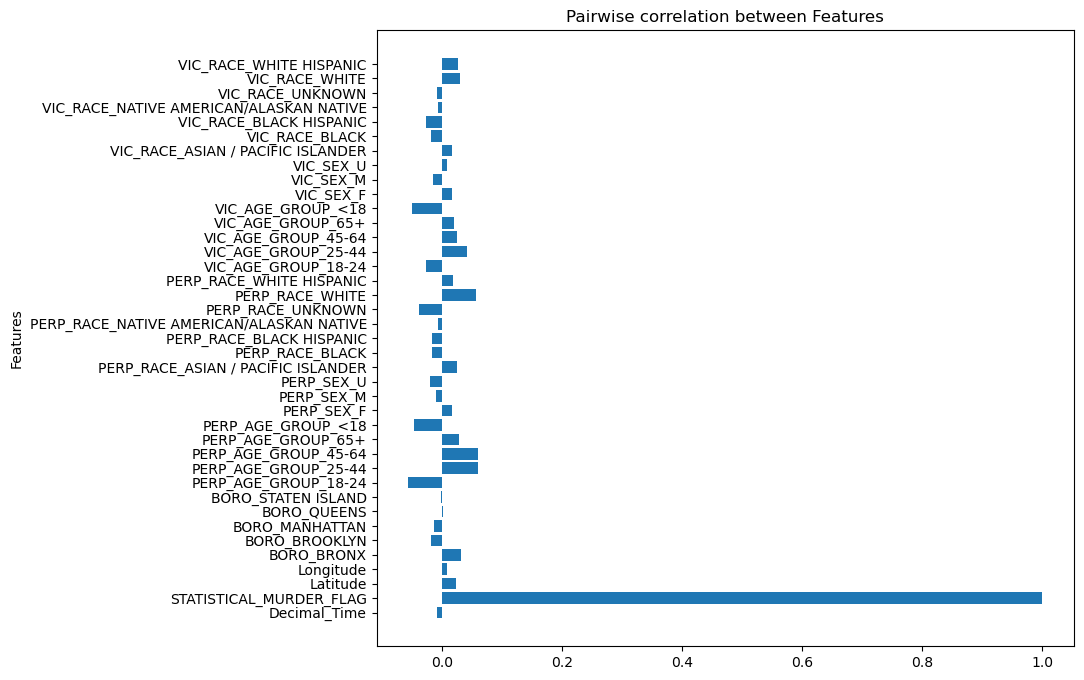

In [13]:
dum = pd.get_dummies(data)

plt.figure(figsize=(9,8))
plt.ylabel('Features')
plt.title('Pairwise correlation between Features')
plt.barh(y=dum.columns, width=dum.corrwith(dum["STATISTICAL_MURDER_FLAG"]))
plt.show()

# Analysis

With the data now cleaned and reduced, I began the analysis. I decided to compare three popular classifiers: *k*-nearest neighbors, (OOB) random forests, and support vector machines.

The best parameters for each classifier were obtained via cross-validation grid search. I tried to use all available parameters the classifiers had with as wide a range of values as I could, whilst considering the computational time. Since random forests offers a good balance between 
high computational cost and time, I decided to use this classifier to test the best *k*-fold value during the grid search.

I started with *k*=3 and *k*=5 and obtained results that were within 0.2% of each other. I tried higher values of *k* but they all led to almost identical values, so I used *k*=3 moving forward. Using *k*=3 also saved about 40 minutes of computation time (~ 50 and ~ 96 minutes, respectively).

In [14]:
def grid_searcher(name, estimator, param_grid, cv, saved=False, trans_data=None):
    '''
    Runs a CV grid search using the given inputs and saves
    the results to a CSV, returning the best parameters.

    INPUTS :       name -              str; name of CSV file
              estimator - estimator object; classifier model
             param_grid -             dict; list of parameters and their values to search over
                     cv -     cv generator; cross-validation technique
                  saved -             bool; if False, runs the gridsearch
             trans_data -         np.array; transformed `x_train` values for SVM classifier

    OUTPUT :        bps -             dict; list of the best-scoring parameters and their values
    '''
    if not saved:
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=-1)

        if trans_data is None: grid_search.fit(x_train_dum.values, y_train)
        else:                  grid_search.fit(trans_data, y_train)
            
        pd.DataFrame.from_dict(grid_search.cv_results_).to_csv(f"{root}/{name}.csv") ## save entire GS to CSV

    csv = pd.read_csv(f"{root}/{name}.csv", index_col=0)
    bps = csv[csv['rank_test_score'] == 1]['params'].to_list()[0]
    bps = ast.literal_eval(bps)                                                      ## convert string-dict to dict
    return bps

### Random Forests

In the parameter grid for the grid search, I left out `ccp_alpha` as including that parameter in the main grid search caused the computation time to exceed 4 hours. This was because there are over 1400 values for `ccp_alpha` alone, which was obtained by fitting a decision tree to the data and pruning it via cost complexity.

To obtain the final model, the resulting `ccp_alpha` values were then used in another grid search (consisting of only this parameter to find its best value) with a different random forest model which had all its other parameters set to the best value obtained from the initial grid search.

In [15]:
RFC_params = {'n_estimators': [5, 10, 50, 100, 250, 500, 1000],
              'criterion'   : ['gini', 'entropy', 'log_loss'],
              'max_depth'   : [1, 3, 5, 10, None],
              'max_features': ['sqrt', 'log2', 1, 5, 10, None],
              'max_samples' : [0.01, 0.1, 0.25, 0.5, 0.75, None]}

In [16]:
rfc3_bp = grid_searcher('rfc_k3', RFC(oob_score=True), RFC_params, KFold(n_splits=3, shuffle=True), saved=True)
rfc5_bp = grid_searcher('rfc_k5', RFC(oob_score=True), RFC_params, KFold(n_splits=5, shuffle=True), saved=True)

In [17]:
print("Best RFC parameters using K=3:", rfc3_bp)
print("Best RFC parameters using K=5:", rfc5_bp)

Best RFC parameters using K=3: {'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'log2', 'max_samples': 0.25, 'n_estimators': 5}
Best RFC parameters using K=5: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.25, 'n_estimators': 500}


In [18]:
rfc_k3 = RFC(n_estimators=rfc3_bp['n_estimators'], criterion=rfc3_bp['criterion'], max_depth=rfc3_bp['max_depth'],
             max_features=rfc3_bp['max_features'], max_samples=rfc3_bp['max_samples'], oob_score=True)

rfc_k5 = RFC(n_estimators=rfc5_bp['n_estimators'], criterion=rfc5_bp['criterion'], max_depth=rfc5_bp['max_depth'],
             max_features=rfc5_bp['max_features'], max_samples=rfc5_bp['max_samples'], oob_score=True)

y_rfc3 = rfc_k3.fit(x_train_dum.values, y_train).score(x_test_dum.values, y_test)
y_rfc5 = rfc_k5.fit(x_train_dum.values, y_train).score(x_test_dum.values, y_test)

/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [19]:
print("Best RFC score using K=3:", y_rfc3)
print("Best RFC score using K=5:", y_rfc5)

Best RFC score using K=3: 0.7592067988668555
Best RFC score using K=5: 0.7597733711048159


In [20]:
RFC_final = {'ccp_alpha': DTC(criterion=rfc_k3.criterion).cost_complexity_pruning_path(x_train_dum.values, y_train)['ccp_alphas']}

In [21]:
rfc_bestp = grid_searcher('rfc_ccp', rfc_k3, RFC_final, KFold(n_splits=3, shuffle=True), saved=True)

In [22]:
rfc_bf = rfc_k3
rfc_bf.ccp_alpha = rfc_bestp['ccp_alpha']

y_rfcb = rfc_bf.fit(x_train_dum.values, y_train).score(x_test_dum.values, y_test)

/Users/saravi/Software/miniforge3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [23]:
print("Best ccp_alpha                        :", rfc_bestp['ccp_alpha'])
print("Best RFC score using ccp_alpha=`bp_bf`:", y_rfcb)

Best ccp_alpha                        : 0.00018419450882639675
Best RFC score using ccp_alpha=`bp_bf`: 0.7597733711048159


### *k*-Nearest Neighbors

This classifier had the most straightforward approach because all of its parameters had a manageable number of values so mulitple grid searchers weren't necessary and the entire computation took only about a half hour.

In [24]:
KNC_params = {'n_neighbors': [1, 3, 5, 10, 25, 50, 100],
              'weights'    : ['uniform', 'distance'],
              'algorithm'  : ['ball_tree', 'kd_tree' ,'brute'],
              'leaf_size'  : [1, 5, 10, 50, 100, 500],
              'p'          : [1, 2, 3, 5, 10, 100]}

In [25]:
knc_bp = grid_searcher('knc', KNC(), KNC_params, KFold(n_splits=3, shuffle=True), saved=True)

In [26]:
knc_bf = KNC(n_neighbors=knc_bp['n_neighbors'], weights=knc_bp['weights'], algorithm=knc_bp['algorithm'], 
             leaf_size=knc_bp['leaf_size'], p=knc_bp['p'])

y_kncb = knc_bf.fit(x_train_dum.values, y_train).score(x_test_dum.values, y_test)

In [27]:
print("Best KNC parameters:", knc_bp)
print("Best KNC score     :", y_kncb)

Best KNC parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}
Best KNC score     : 0.7597733711048159


### Support Vector Machine

The same approach to random forests was taken here, not because there were lots of parameters with a wide range of values but because of its high computation time.

During an initial fit, a warning was thrown that said the solver terminated early so I should consider transforming the data using either `MinMaxScaler` or `StandardScaler`.

So, in an attempt to mitigate the warning, I transformed the data using both Scalers before fitting it to see if there were any quantifiable differences. However, the data transformed via the `MinMaxScaler` took about ~ 45 minutes to compute while the `StandardScaler` took over 5 hours! And despite some of the values for the best parameter changing between both Scalers, the resulting accuracy was the exact same. I stuck with the `MinMaxScaler` data moving forward.

There was one other parameter that I left out in the initial grid search, `degree`. So I repeated the search using only that parameter with the SVM model set up with the best parameters from the initial grid search, to obtain the final model.

In [28]:
x_train_mms = MinMaxScaler().fit_transform(x_train_dum.values, y_train)
x_test_mms  = MinMaxScaler().fit_transform(x_test_dum.values, y_test)

x_train_sds = StandardScaler().fit_transform(x_train_dum.values, y_train)
x_test_sds  = StandardScaler().fit_transform(x_test_dum.values, y_test)

In [29]:
SVC_params = {'C'       : [0.1, 1, 10, 100, 1000],
              'kernel'  : ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma'   : ['scale', 'auto'],
              'max_iter': [5, 10, 25, -1],}

In [30]:
svc_bp = grid_searcher('svc_mms', SVC(shrinking=True), SVC_params, KFold(n_splits=3, shuffle=True), saved=True, trans_data=x_train_mms)
svc_bf = SVC(C=svc_bp['C'], kernel=svc_bp['kernel'], gamma=svc_bp['gamma'], max_iter=svc_bp['max_iter'], shrinking=True, probability=True)

y_svcb = svc_bf.fit(x_train_mms, y_train).score(x_test_mms, y_test)


# svc_bp = grid_searcher('svc_sds', SVC(shrinking=True), SVC_params, KFold(n_splits=3, shuffle=True), saved=True, trans_data=x_train_sds)
# svc_bf = SVC(C=svc_bp['C'], kernel=svc_bp['kernel'], gamma=svc_bp['gamma'], max_iter=svc_bp['max_iter'], shrinking=True)

# y_svcb = svc_bf.fit(x_train_sds, y_train).score(x_test_sds, y_test)

In [31]:
print("Best SVC (MMS) parameters:", svc_bp)
print("Best SVC (MMS) score     :", y_svcb)

Best SVC (MMS) parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1}
Best SVC (MMS) score     : 0.7597733711048159


In [32]:
SVC_final = {'degree': list(range(1, 105, 5))}

In [33]:
svc_bestp = grid_searcher('svc_deg', svc_bf, SVC_final, KFold(n_splits=3, shuffle=True), saved=True, trans_data=x_train_mms)

In [34]:
svc_bf.degree = svc_bestp['degree']

y_svcb = svc_bf.fit(x_train_mms, y_train).score(x_test_mms, y_test)

In [35]:
print("Best degree                            :", svc_bestp['degree'])
print("Best SVC score using degree=`svc_bestp`:", y_svcb)

Best degree                            : 6
Best SVC score using degree=`svc_bestp`: 0.7597733711048159


# Results

### Feature Importance using Random Forests

We can see right away from looking at the list of important features in the Random Forest model that there are several features that stand out as the most important but it also comes with large error bars. It's interesting that many of the features have large error bars which suggests that shuffling the data can lead to different outcomes. 

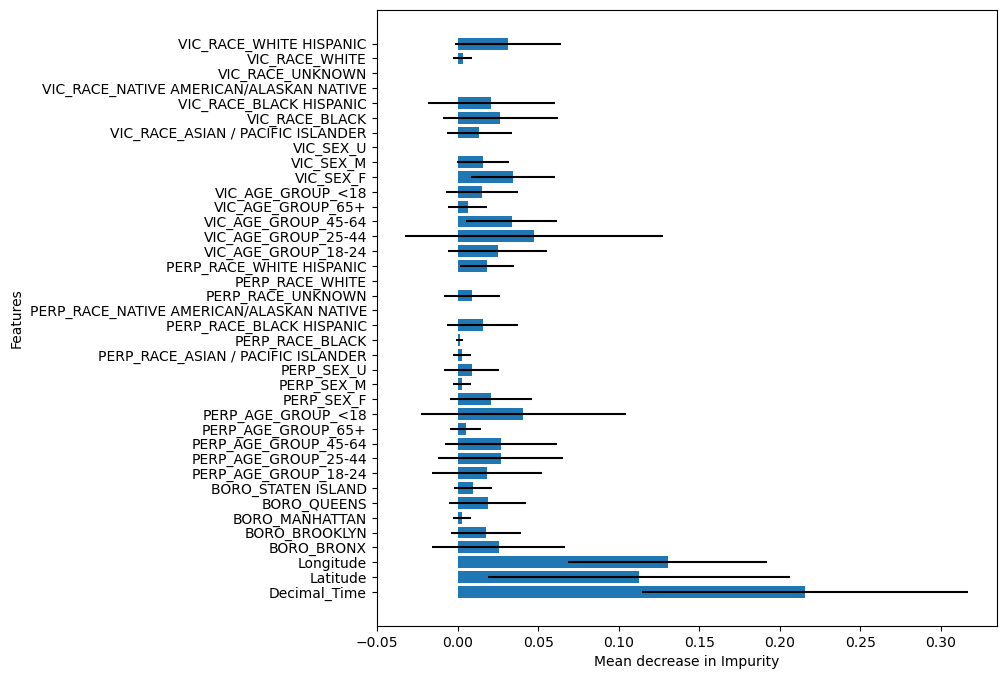

In [36]:
x = rfc_bf.feature_importances_
y = x_train_dum.columns.to_list()
e = np.std([tree.feature_importances_ for tree in rfc_bf.estimators_], axis=0)

plt.figure(figsize=(8,8))
plt.xlabel('Mean decrease in Impurity')
plt.ylabel('Features')
plt.barh(y, x, xerr=e)
plt.show()

### Training set accuracy for various ccp_alphas

I did notice when the `ccp_alpha` values were first generated that they were all very close to each other and very close to zero. I wasn't sure how big of an effect they'd have on the model but the plot below clearly shows that regardless of whether `ccp_alpha=min(ccp_alphas)` or `ccp_alpha=max(ccp_alphas)`, the classifier accuracy hardly changes.

This means pruning the forest had insignificant effects.

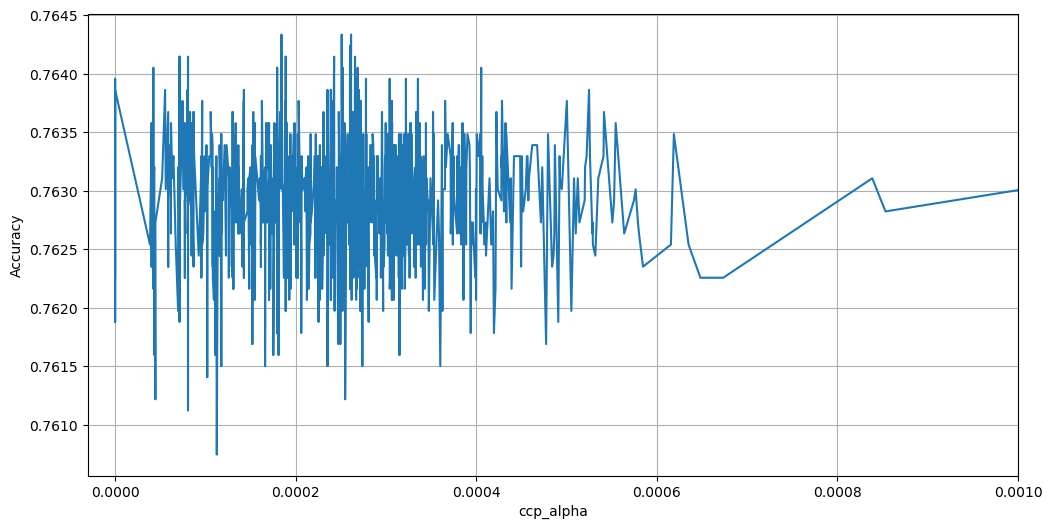

In [37]:
df = pd.read_csv(f"{root}/rfc_ccp.csv", index_col=0)

plt.figure(figsize=(12,6))
plt.plot(df['param_ccp_alpha'], df['mean_test_score'])
plt.xlim(-0.00003, 0.001)
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### Grid Search

Here, I plotted the mean test scores from all of the grid searches. 

Despite the numerous iterations involving all the different parameters, the plot below shows that there were actually lots of different sets of parameters that all yielded very similar accuracy scores. This is evident by the fact that the *k*-nearest neighbor and SVM plots are cylic very early on, whereas the random forest classifier only becomes cylic after ~750 iterations.

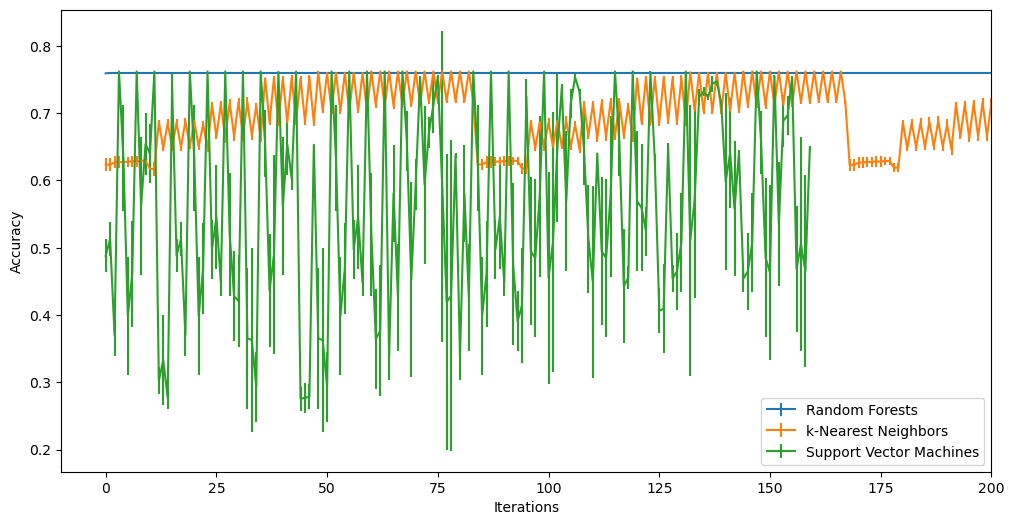

In [38]:
def get_xye(file):
    d = pd.read_csv(f"{root}/{file}.csv")
    x = range(len(d))
    y = d['mean_test_score']
    e = d['std_test_score']
    return x, y, e
    

x_rfc, y_rfc, err_rfc = get_xye('rfc_k3')
x_knc, y_knc, err_knc = get_xye('knc')
x_svc, y_svc, err_svc = get_xye('svc_mms')


plt.figure(figsize=(12,6))
plt.errorbar(x=x_rfc, y=y_rfc, yerr=err_rfc, label='Random Forests')
plt.errorbar(x=x_knc, y=y_knc, yerr=err_knc, label='k-Nearest Neighbors')
plt.errorbar(x=x_svc, y=y_svc, yerr=err_svc, label='Support Vector Machines')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.xlim(-10, 200)
plt.legend(loc=4)
plt.show()

### ROC and Precision-Recall Curves

Finally, plotting the ROC and precision-recall curves undoubtedly shows that all three models are lacking substantially.

The SVM classifier performs no better than random chance while random forests and *k*-nearest neighbors perform marginally better, which is interesting because SVMs are better suited for binary classifiation.

However, it makes sense to me that *k*-nearest neighbors performed marginally better than random forests since it's better suited for handling many categorical features. And because this classifier tends to favor localized data, it feels approrpiate to use this classifier on shooting-related data, as many shooting incidents are also localized.

In [39]:
y_prob_rfc           = rfc_bf.predict_proba(x_test_dum.values)[:,1]
y_prob_knc           = knc_bf.predict_proba(x_test_dum.values)[:,1]
y_prob_svc           = svc_bf.predict_proba(x_test_dum.values)[:,1]


fp_rfc, tp_rfc, _    = roc_curve(y_test,  y_prob_rfc)
fp_knc, tp_knc, _    = roc_curve(y_test,  y_prob_knc)
fp_svc, tp_svc, _    = roc_curve(y_test,  y_prob_svc)

auc_rfc              = roc_auc_score(y_test, y_prob_rfc)
auc_knc              = roc_auc_score(y_test, y_prob_knc)
auc_svc              = roc_auc_score(y_test, y_prob_svc)


pres_rfc, rec_rfc, _ = precision_recall_curve(y_test, y_prob_rfc)
pres_knc, rec_knc, _ = precision_recall_curve(y_test, y_prob_knc)
pres_svc, rec_svc, _ = precision_recall_curve(y_test, y_prob_svc)

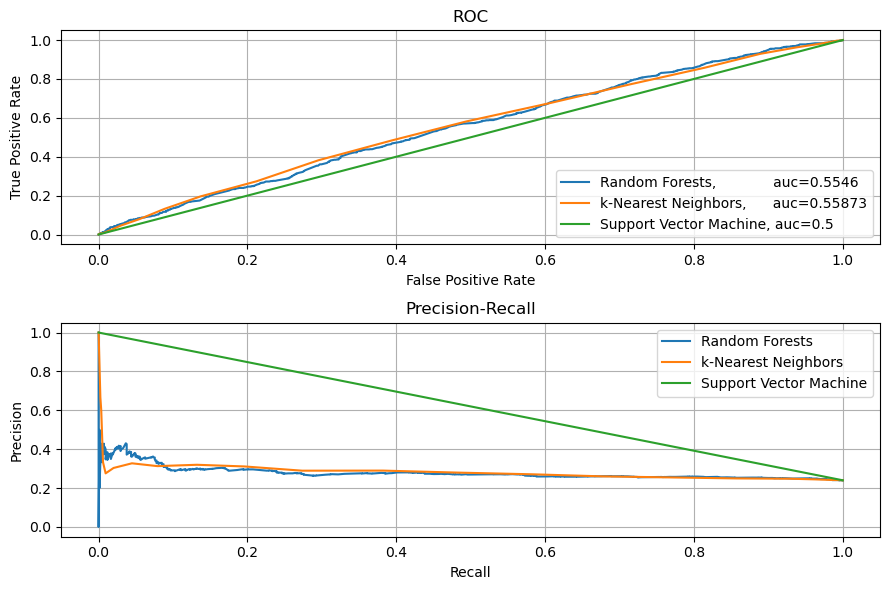

In [40]:
fig, (ax1, ax2) = plt.subplots(figsize=(9,6), nrows=2, ncols=1)

ax1.plot(fp_rfc, tp_rfc, label=f"Random Forests,             auc={round(auc_rfc, 5)}")
ax1.plot(fp_knc, tp_knc, label=f"k-Nearest Neighbors,      auc={round(auc_knc, 5)}")
ax1.plot(fp_svc, tp_svc, label=f"Support Vector Machine, auc={round(auc_svc, 5)}")
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC')
ax1.legend(loc=4)
ax1.grid()

ax2.plot(rec_rfc, pres_rfc, label=f"Random Forests")
ax2.plot(rec_knc, pres_knc, label=f"k-Nearest Neighbors")
ax2.plot(rec_svc, pres_svc, label=f"Support Vector Machine")
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall')
ax2.legend(loc=1)
ax2.grid()

fig.tight_layout()

### Shooting and Survival Rates

Plotting the shootings as a histogram helps highlight the patterns across all five boroughs. A strong correlation can now be seen between the likelihood of a shooting occuring and the time of day. The fall and rise of the total amount of shooting incidents seem like they’d be good candidates to test models to predict the amount of shootings for any given hour.

Could there also be a connection between the ages of the people involved and the time it took place?

In [41]:
def life_n_death(dat):
    '''
    The # of shootings occurring within a certain time interval
    is calculated, including the amount that died and survived,
    and converted to a DataFrame.
    
    INPUT  : dat - DataFrame; shooting incident locations in a boro
    OUTPUT : out - DataFrame; amount of casualties in a boro
    '''
    occr, bins = np.histogram(dat.t_dec, bins=np.arange(0, 24.1, .25))
    hourly_int = {a:[] for a, b in enumerate(bins[:-1])} ## quarter hour intervals
    
    for hr in range(1, len(bins)):
        period = dat[(dat.t_dec >= bins[hr-1]) & (dat.t_dec < bins[hr])]
        
        te = len(period[period.Dead == True])            ## amount of deaths
        fe = len(period[period.Dead == False])           ## amount of survivors
        
        assert sum([te, fe]) == occr[hr-1]
        hourly_int[hr-1].append(te)
        hourly_int[hr-1].append(fe)
        try:
            hourly_int[hr-1].append((fe/(te+fe))*100)
        except ZeroDivisionError:                        ## if no data, 100% chance of living
            hourly_int[hr-1].append(100)
        hourly_int[hr-1].append(bins[hr-1])
    
    out = pd.DataFrame(hourly_int.values(), index=hourly_int.keys(), \
                       columns=['Died', 'Survived', 'frac', 't_dec'])

    times = []                                           ## convert decimal time to readable
    for _ in out.index:
        t = str(out.loc[_].t_dec)
        h = int(t[:t.find('.')])
        m = int(float(t[t.find('.'):])*60)

        if h > 12: h = h-12
        if h == 0: h = "12\nAM"
        if h == 12: h = "12\nPM"
        c = h
        times.append(c)
    
    out['t_disp'] = times
    return out



def plotter2(i, sub, save=False):
    '''
    The amount of deaths and survivors for a given borough
    is plotted in a bar chart spanning 24 hours. A "survival rate"
    line is overplotted.
    
    INPUT  :    i -          int; counter for dataset
              sub -  AxesSubPlot; iteration in axes subplots
             save -         bool; saved plot if True
    '''
    df = life_n_death(data_in[i])

    p1 = df.plot(y=['Died', 'Survived'], kind="bar", color=['red', 'blue'], width=1,legend=False, stacked=True, figsize=(100, 105), ax=sub)
    p2 = df.plot(y='frac', ax=p1, sharex=p1, color='k', lw=5, mark_right=False, legend=False, secondary_y=True)

    p1.set_title(f"{names_5[i]}")
    handles, labels = p1.get_legend_handles_labels()
    fig.legend(handles, labels, loc=9, ncol=3, bbox_to_anchor=(0.5, .96))
    _ = p1.set_xticklabels(df['t_disp'], ha='left')
    _ = [b.set_visible(False) for a, b in enumerate(p1.xaxis.get_ticklabels()) if a % 4 != 0]
    
    if save:
        plt.savefig(f"{root}/shooting_histogram.png")
    return

In [42]:
dat2 = pd.DataFrame({'Boro' : data['BORO'], 't_dec' : data['Decimal_Time'], 'Dead' : data['STATISTICAL_MURDER_FLAG'], 
                     'Perp' : data['PERP_RACE'], 'Vic' : data['VIC_RACE']})

## filter for boroughs
bx = dat2.iloc[dat2[dat2['Boro'] == 'BRONX'].index]
qs = dat2.iloc[dat2[dat2['Boro'] == 'QUEENS'].index]
bn = dat2.iloc[dat2[dat2['Boro'] == 'BROOKLYN'].index]
mn = dat2.iloc[dat2[dat2['Boro'] == 'MANHATTAN'].index]
si = dat2.iloc[dat2[dat2['Boro'] == 'STATEN ISLAND'].index]

data_in = [si, mn, bx, bn, qs]
names_5 = ['Staten Island', 'Manhattan', 'Bronx', 'Brooklyn', 'Queens']

In [43]:
plt.rcParams.update({'font.size':105})
fig, axes = plt.subplots(5, 1)

fig.text(.08, 0.46, '# of shootings', ha='center', rotation=90)
fig.text(.94, 0.44, '% chance of survival', ha='center', rotation=270)

for a, b in enumerate(axes):
    plotter2(a, b, False)